In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import tensorflow as tf
from keras_tuner import RandomSearch

from constants.klass_mappings import klass_mappings
from constants.transliterations import transliterations
from models.model_1 import Model1

In [2]:
X_train = pd.read_csv('./data/preprocessing/train_x_24x24.csv')
X_test = pd.read_csv('./data/preprocessing/test_x_24x24.csv')
y_train = pd.read_csv('./data/train_y.csv')
y_test = pd.read_csv('./data/test_y.csv')

In [3]:
target_size = (24, 24)

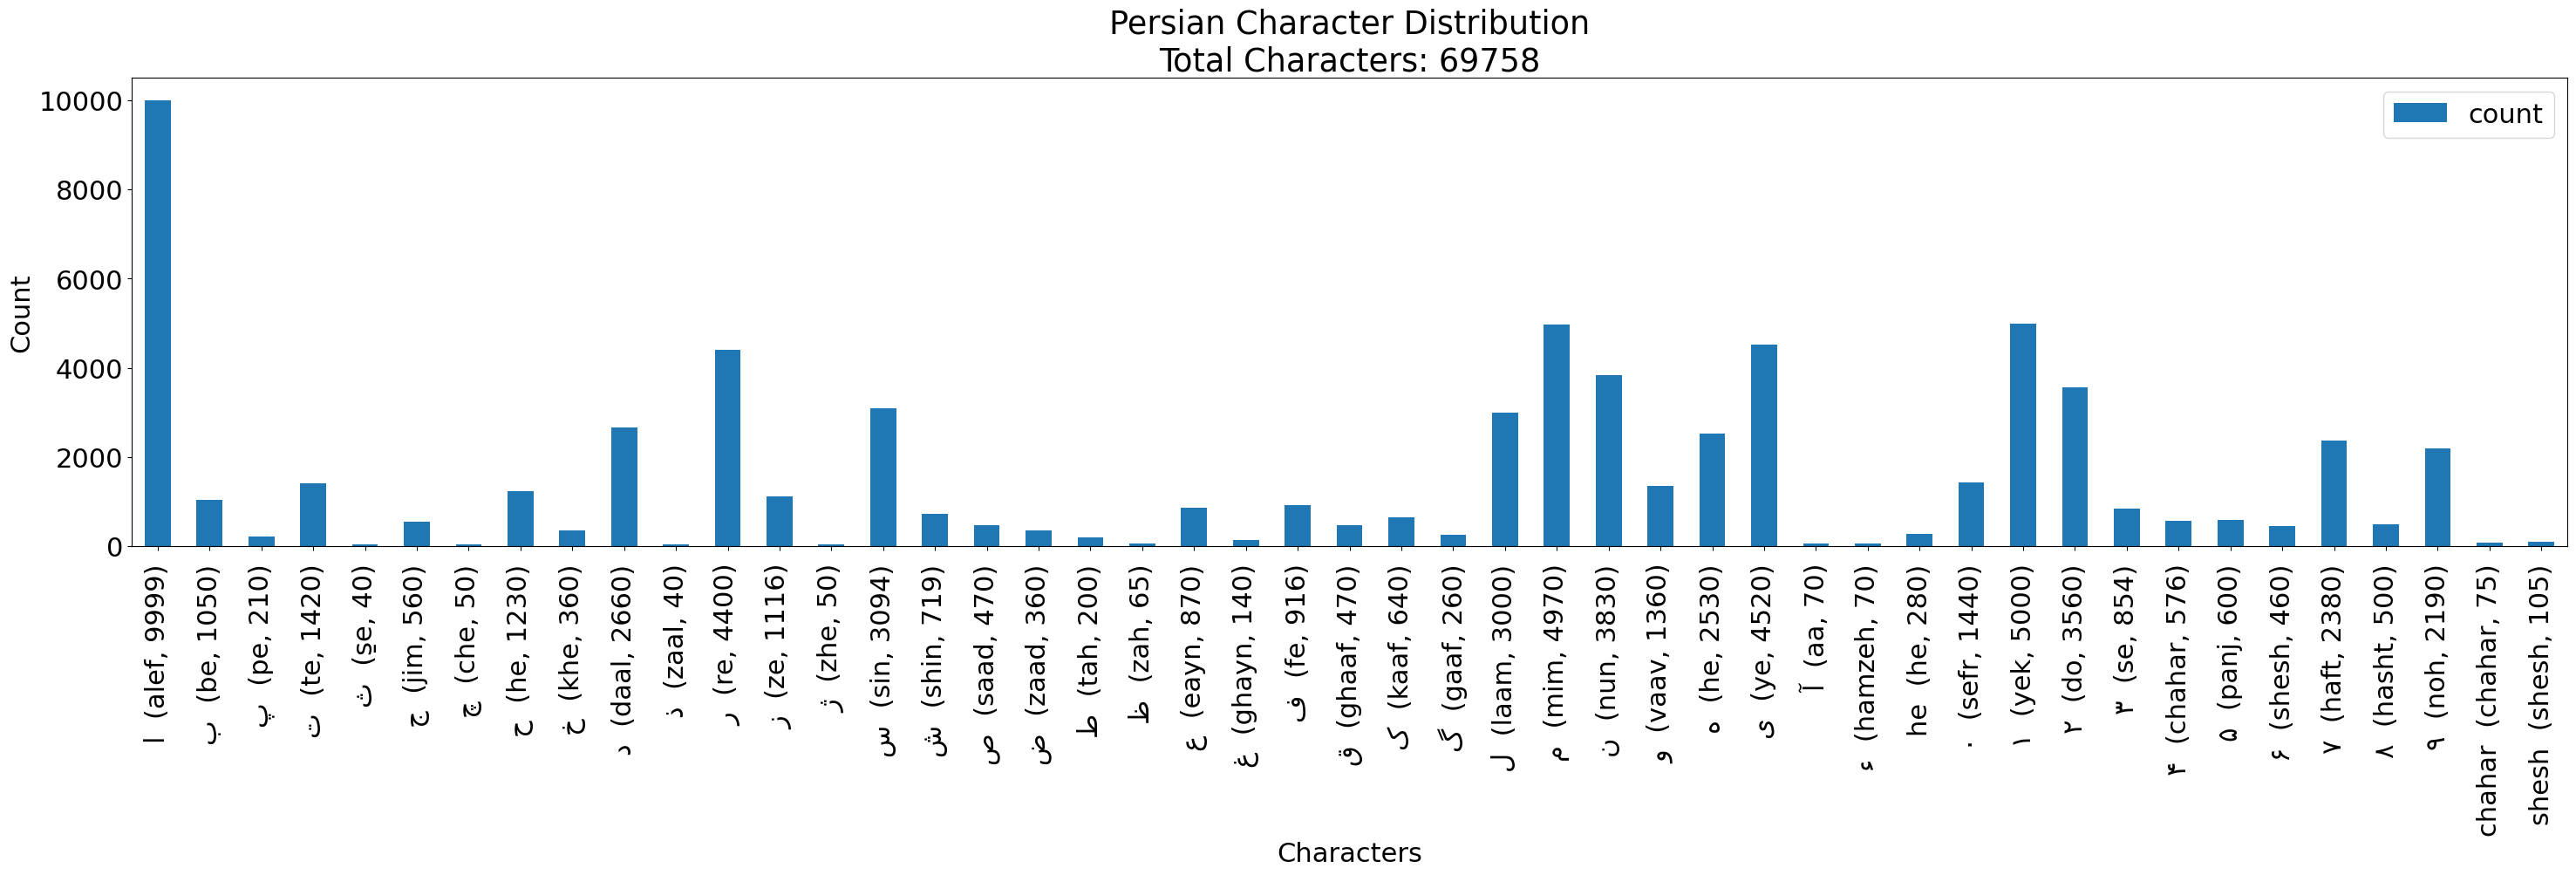

In [4]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
mappings_df = y_train.groupby('1')['1'].count().to_frame()
mappings_df = mappings_df.rename(columns={'1': 'count'})
mappings_df['klass'] = mappings_df.index
mappings_df['character'] = mappings_df['klass'].apply(lambda x: klass_mappings[x])
mappings_df['transliteration'] = mappings_df['klass'].apply(lambda x: transliterations[x])
mappings_df['klass_transliteration'] = mappings_df['klass'].apply(lambda x: f'{klass_mappings[x]}  ({transliterations[x]}, {mappings_df["count"][x]}) ')
mappings_df['proportion'] = mappings_df['klass'].apply(lambda x: mappings_df['count'][x] / mappings_df['count'][1])
fig = mappings_df[['klass_transliteration', 'count']].plot(kind='bar', xlabel=f'Characters', ylabel='Count', title=f"Persian Character Distribution\nTotal Characters: {X_train.shape[0]}", x='klass_transliteration', figsize=(30,10)).get_figure()
fig.tight_layout()
fig.subplots_adjust(bottom=0.35)
fig.savefig('./images/character_distribution.png')

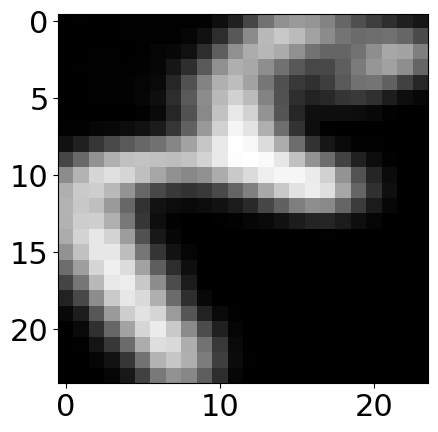

In [5]:
plt.imshow(X_train.iloc[18027].values.reshape(target_size), cmap = "gray_r")

In [6]:
# take a small random sample for tuning purposes
X_train_sample = X_train.sample(n=15000, random_state=6)
y_train_sample = y_train.loc[X_train_sample.index]
y_train_sample.groupby("1")["1"].count()

1
1     2208
2      229
3       42
4      323
5       14
6      111
7       13
8      262
9       83
10     560
11       7
12     953
13     226
14       6
15     693
16     145
17     103
18      90
19      41
20       9
21     188
22      26
23     190
24     101
25     139
26      59
27     622
28    1059
29     867
30     280
31     526
32     944
33      18
34      17
35      74
36     308
37    1044
38     753
39     199
40     130
41     124
42     103
43     501
44     116
45     459
46      15
47      20
Name: 1, dtype: int64

In [9]:
num_classes = 48
input_shape = (576, 1)
desired_shape = (24, 24, 1)

In [10]:
tuner = RandomSearch(
    Model1(num_classes=num_classes, input_shape=input_shape, desired_shape=desired_shape),
        objective="val_accuracy",
        max_trials=100,
        max_consecutive_failed_trials=10,
        executions_per_trial=1,
        directory='tuning',
        project_name="hyperparams",
        overwrite=True
    )
tuner.search(X_train_sample, y_train_sample, epochs=1, validation_data=(X_train_sample, y_train_sample))

Trial 100 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.8485333323478699
Total elapsed time: 00h 05m 35s


In [11]:
model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 24, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 23, 23, 30)     │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3630)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │       174,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,438 (681.40 KB)

 Trainable params: 174,438 (681.40 KB)

 Non-trainable params: 0 (0.00 B)

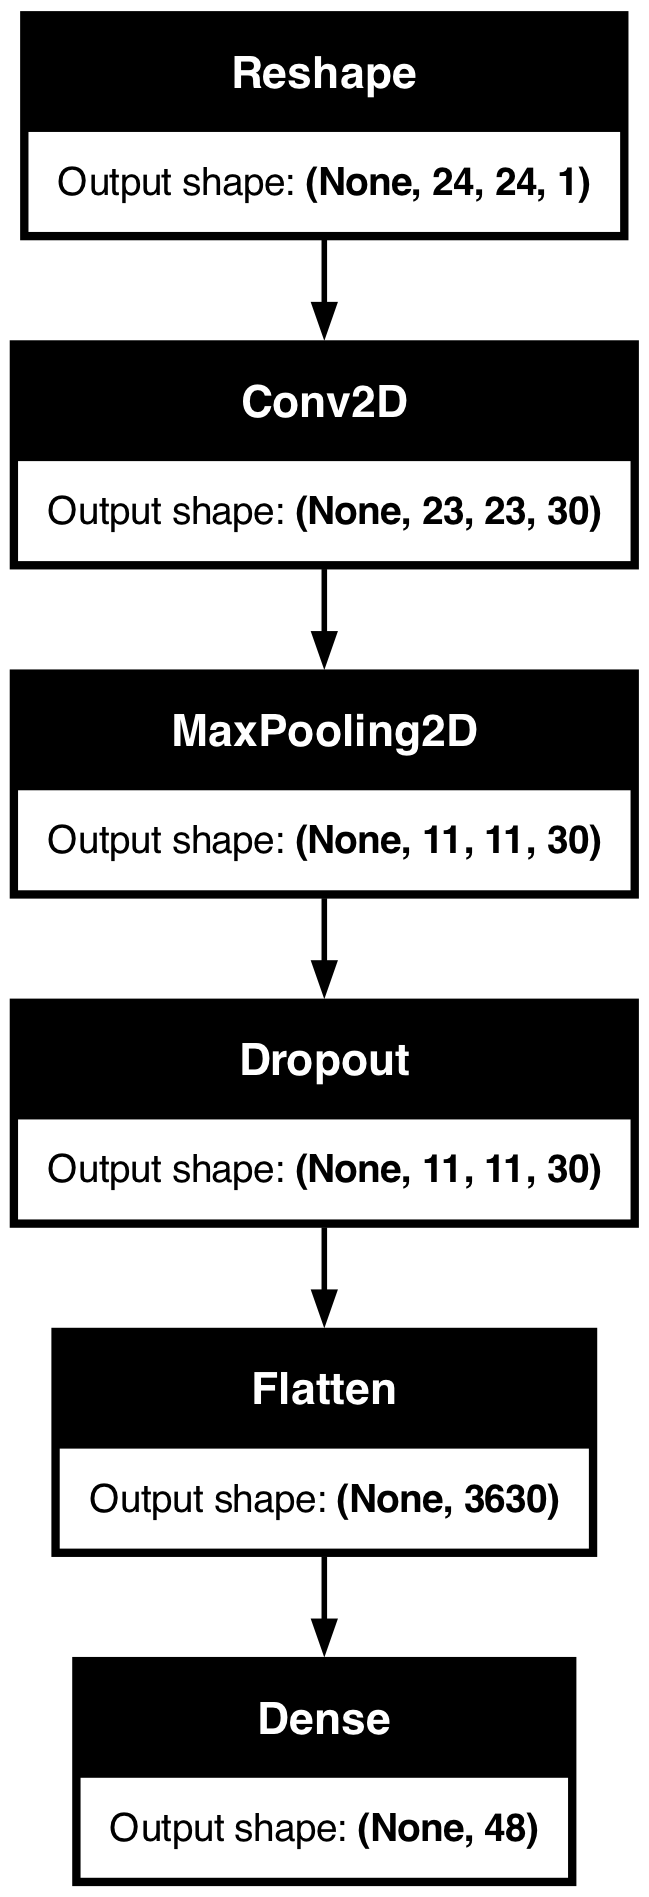

In [14]:
tf.keras.utils.plot_model(model, to_file='./images/model_1_24x24.png', show_shapes=True)

In [13]:
best_hyperparams = tuner.get_best_hyperparameters(10)[0]
best_hyperparams.values

{'conv_2_filter': 30,
 'conv_2_kernel': 2,
 'activation': 'relu',
 'pool_size': 2,
 'strides': 2,
 'dropout': 0.1,
 'optimizer': 'rmsprop',
 'loss': 'sparse_categorical_crossentropy',
 'batch_size': 20}